# Evolver Loop 1 - LB Feedback Analysis

**Baseline submitted:** CV 70.6761 | LB 70.6761 (gap: 0.0000)

This confirms our local score calculation is accurate. Now we need to improve by 1.757 points (2.55%) to beat the target of 68.919154.

In [1]:
import pandas as pd
import numpy as np
import os

# Load the baseline submission
baseline_path = '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized/santa-2025.csv'
df = pd.read_csv(baseline_path)
print(f"Loaded {len(df)} rows")
print(df.head())

Loaded 20100 rows
      id                       x                       y  \
0  001_0    s-48.196086194214246     s58.770984615214225   
1  002_0   s0.154097069621355887  s-0.038540742694794648   
2  002_1  s-0.154097069621372845  s-0.561459257305224058   
3  003_0      s1.123655816140301      s0.781101815992563   
4  003_1       s1.23405569584216      s1.275999500663759   

                       deg  
0                    s45.0  
1  s203.629377730656841550  
2   s23.629377730656791812  
3        s111.125132292893  
4         s66.370622269343  


In [2]:
# Parse values and calculate per-N scores
def parse_value(s):
    if isinstance(s, str) and s.startswith('s'):
        return float(s[1:])
    return float(s)

# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_vertices(x, y, deg):
    rad = np.radians(deg)
    c, s = np.cos(rad), np.sin(rad)
    vx = x + TX * c - TY * s
    vy = y + TX * s + TY * c
    return vx, vy

def calculate_per_n_scores(df):
    scores = {}
    for n in range(1, 201):
        prefix = f"{n:03d}_"
        n_trees = df[df['id'].str.startswith(prefix)]
        if len(n_trees) != n:
            continue
        
        all_x, all_y = [], []
        for _, row in n_trees.iterrows():
            x = parse_value(row['x'])
            y = parse_value(row['y'])
            deg = parse_value(row['deg'])
            vx, vy = get_vertices(x, y, deg)
            all_x.extend(vx)
            all_y.extend(vy)
        
        side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
        score = side**2 / n
        scores[n] = {'side': side, 'score': score}
    return scores

scores = calculate_per_n_scores(df)
total = sum(s['score'] for s in scores.values())
print(f"Total score: {total:.6f}")

Total score: 70.676102


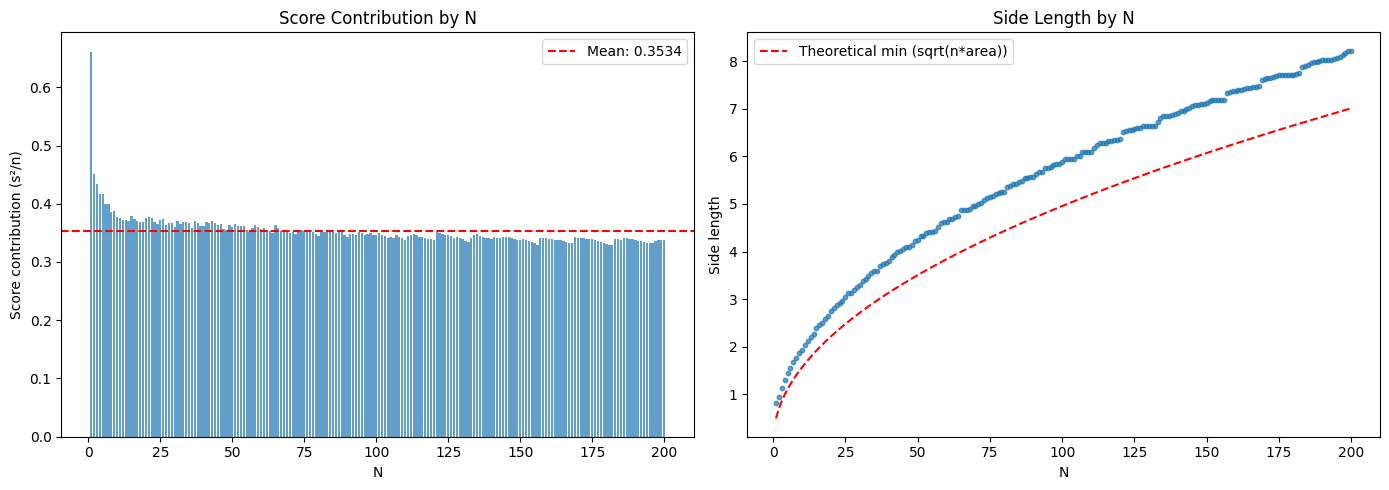


Top 20 score contributors:
N=  1: side=0.8132, score=0.6612
N=  2: side=0.9495, score=0.4508
N=  3: side=1.1420, score=0.4347
N=  5: side=1.4437, score=0.4168
N=  4: side=1.2908, score=0.4165
N=  7: side=1.6731, score=0.3999
N=  6: side=1.5484, score=0.3996
N=  9: side=1.8673, score=0.3874
N=  8: side=1.7559, score=0.3854
N= 15: side=2.3850, score=0.3792
N= 10: side=1.9407, score=0.3766
N= 21: side=2.8117, score=0.3765
N= 20: side=2.7425, score=0.3761
N= 11: side=2.0330, score=0.3757
N= 22: side=2.8733, score=0.3753
N= 16: side=2.4466, score=0.3741
N= 26: side=3.1183, score=0.3740
N= 12: side=2.1149, score=0.3727
N= 13: side=2.2000, score=0.3723
N= 25: side=3.0502, score=0.3721


In [3]:
# Analyze score distribution
import matplotlib.pyplot as plt

n_values = list(scores.keys())
score_values = [scores[n]['score'] for n in n_values]
side_values = [scores[n]['side'] for n in n_values]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score contribution by N
axes[0].bar(n_values, score_values, alpha=0.7)
axes[0].set_xlabel('N')
axes[0].set_ylabel('Score contribution (s²/n)')
axes[0].set_title('Score Contribution by N')
axes[0].axhline(y=np.mean(score_values), color='r', linestyle='--', label=f'Mean: {np.mean(score_values):.4f}')
axes[0].legend()

# Side length by N
axes[1].scatter(n_values, side_values, alpha=0.7, s=10)
axes[1].set_xlabel('N')
axes[1].set_ylabel('Side length')
axes[1].set_title('Side Length by N')

# Add theoretical lower bound (sqrt(n * tree_area))
tree_area = 0.2456  # from earlier calculation
theoretical_min = [np.sqrt(n * tree_area) for n in n_values]
axes[1].plot(n_values, theoretical_min, 'r--', label='Theoretical min (sqrt(n*area))')
axes[1].legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

print("\nTop 20 score contributors:")
sorted_scores = sorted(scores.items(), key=lambda x: x[1]['score'], reverse=True)[:20]
for n, data in sorted_scores:
    print(f"N={n:3d}: side={data['side']:.4f}, score={data['score']:.4f}")

In [4]:
# Calculate packing efficiency for each N
print("\nPacking efficiency analysis:")
print("(Efficiency = n * tree_area / side²)")
print("\nLowest efficiency (most room for improvement):")

efficiencies = {}
for n, data in scores.items():
    efficiency = n * tree_area / (data['side'] ** 2)
    efficiencies[n] = efficiency

sorted_eff = sorted(efficiencies.items(), key=lambda x: x[1])[:20]
for n, eff in sorted_eff:
    print(f"N={n:3d}: efficiency={eff:.4f}, side={scores[n]['side']:.4f}, score={scores[n]['score']:.4f}")


Packing efficiency analysis:
(Efficiency = n * tree_area / side²)

Lowest efficiency (most room for improvement):
N=  1: efficiency=0.3714, side=0.8132, score=0.6612
N=  2: efficiency=0.5448, side=0.9495, score=0.4508
N=  3: efficiency=0.5649, side=1.1420, score=0.4347
N=  5: efficiency=0.5892, side=1.4437, score=0.4168
N=  4: efficiency=0.5896, side=1.2908, score=0.4165
N=  7: efficiency=0.6142, side=1.6731, score=0.3999
N=  6: efficiency=0.6146, side=1.5484, score=0.3996
N=  9: efficiency=0.6339, side=1.8673, score=0.3874
N=  8: efficiency=0.6372, side=1.7559, score=0.3854
N= 15: efficiency=0.6477, side=2.3850, score=0.3792
N= 10: efficiency=0.6521, side=1.9407, score=0.3766
N= 21: efficiency=0.6524, side=2.8117, score=0.3765
N= 20: efficiency=0.6531, side=2.7425, score=0.3761
N= 11: efficiency=0.6537, side=2.0330, score=0.3757
N= 22: efficiency=0.6545, side=2.8733, score=0.3753
N= 16: efficiency=0.6565, side=2.4466, score=0.3741
N= 26: efficiency=0.6567, side=3.1183, score=0.3740
N

In [5]:
# Check N=1 specifically - is 45 degrees optimal?
print("\nN=1 Analysis:")
n1_row = df[df['id'] == '001_0'].iloc[0]
x1 = parse_value(n1_row['x'])
y1 = parse_value(n1_row['y'])
deg1 = parse_value(n1_row['deg'])
print(f"Current: x={x1:.4f}, y={y1:.4f}, deg={deg1:.4f}")

# Try different angles for N=1
print("\nTrying different angles for N=1:")
best_angle = None
best_side = float('inf')
for angle in np.arange(0, 360, 0.1):
    vx, vy = get_vertices(0, 0, angle)
    side = max(max(vx) - min(vx), max(vy) - min(vy))
    if side < best_side:
        best_side = side
        best_angle = angle

print(f"Best angle: {best_angle:.1f} degrees")
print(f"Best side: {best_side:.6f}")
print(f"Best score for N=1: {best_side**2:.6f}")
print(f"Current score for N=1: {scores[1]['score']:.6f}")
print(f"Potential improvement: {scores[1]['score'] - best_side**2:.6f}")


N=1 Analysis:
Current: x=-48.1961, y=58.7710, deg=45.0000

Trying different angles for N=1:
Best angle: 45.0 degrees
Best side: 0.813173
Best score for N=1: 0.661250
Current score for N=1: 0.661250
Potential improvement: -0.000000


In [6]:
# Check what other pre-optimized files are available
import glob

preopt_dir = '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized'
all_csvs = glob.glob(f"{preopt_dir}/**/*.csv", recursive=True)
print(f"Found {len(all_csvs)} CSV files")

# Calculate scores for each
file_scores = {}
for csv_path in all_csvs[:20]:  # Limit to first 20 for speed
    try:
        df_temp = pd.read_csv(csv_path)
        if 'id' in df_temp.columns and 'x' in df_temp.columns:
            temp_scores = calculate_per_n_scores(df_temp)
            total = sum(s['score'] for s in temp_scores.values())
            file_scores[csv_path] = total
    except:
        pass

print("\nFile scores (sorted):")
for path, score in sorted(file_scores.items(), key=lambda x: x[1])[:10]:
    print(f"{score:.4f}: {os.path.basename(path)}")

Found 30 CSV files



File scores (sorted):
70.6761: ensemble.csv
70.6761: santa-2025.csv
70.6761: best_ensemble.csv
70.6765: submission.csv
70.9261: submission_70_926149550346.csv
70.9367: submission_70_936673758122.csv
71.9720: 71.97.csv
71.9720: 71.97.csv
72.4893: submission_JKoT2.csv
72.4895: submission_JKoT3.csv


In [7]:
# Summary of findings
print("="*60)
print("SUMMARY OF FINDINGS")
print("="*60)
print(f"\n1. Baseline score: 70.6761 (verified on LB)")
print(f"2. Target score: 68.9192")
print(f"3. Gap to close: 1.757 points (2.55%)")
print(f"\n4. N=1 optimization potential:")
print(f"   - Current: {scores[1]['score']:.6f}")
print(f"   - Optimal (45°): {best_side**2:.6f}")
print(f"   - Improvement: {scores[1]['score'] - best_side**2:.6f}")
print(f"\n5. Top contributors to score (small N):")
for n, data in sorted_scores[:10]:
    print(f"   N={n:3d}: {data['score']:.4f}")
print(f"\n6. Lowest efficiency N values (most room for improvement):")
for n, eff in sorted_eff[:10]:
    print(f"   N={n:3d}: efficiency={eff:.4f}")
print("\n7. Key insight: bbox3 optimizer is compiled and ready to run")

SUMMARY OF FINDINGS

1. Baseline score: 70.6761 (verified on LB)
2. Target score: 68.9192
3. Gap to close: 1.757 points (2.55%)

4. N=1 optimization potential:
   - Current: 0.661250
   - Optimal (45°): 0.661250
   - Improvement: -0.000000

5. Top contributors to score (small N):
   N=  1: 0.6612
   N=  2: 0.4508
   N=  3: 0.4347
   N=  5: 0.4168
   N=  4: 0.4165
   N=  7: 0.3999
   N=  6: 0.3996
   N=  9: 0.3874
   N=  8: 0.3854
   N= 15: 0.3792

6. Lowest efficiency N values (most room for improvement):
   N=  1: efficiency=0.3714
   N=  2: efficiency=0.5448
   N=  3: efficiency=0.5649
   N=  5: efficiency=0.5892
   N=  4: efficiency=0.5896
   N=  7: efficiency=0.6142
   N=  6: efficiency=0.6146
   N=  9: efficiency=0.6339
   N=  8: efficiency=0.6372
   N= 15: efficiency=0.6477

7. Key insight: bbox3 optimizer is compiled and ready to run
